# Figures for the `autokey` task

**Learning the Enigma with Recurrent Neural Networks**

Sam Greydanus. January 2017. MIT License.

In [1]:
import numpy as np
import tensorflow as tf
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('..')
from stacked_rnn import StackedRNN
from train_utils import *
from autokey import Autokey

/Users/Sam/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
tf.app.flags.DEFINE_bool("train", True, "Run the train loop (else eval model)")
tf.app.flags.DEFINE_bool("vary_mem", False, "Train this model repeatedly for different memory sizes")
tf.app.flags.DEFINE_integer("key_len", 6, "Maximum length of key for encoding/decoding message")
tf.app.flags.DEFINE_integer("tsteps", 20, "Number of timesteps for backpropagation")
tf.app.flags.DEFINE_integer("rnn_size", 256, "Number of hidden units in the rnn")
tf.app.flags.DEFINE_integer("ncells", 1, "Number of recurrent cells to stack")
tf.app.flags.DEFINE_integer("batch_size", 50, "Size of batch in minibatch gradient descent")
tf.app.flags.DEFINE_integer("save_every", 5000, "Save model after this number of train steps")
tf.app.flags.DEFINE_integer("total_steps", 250000, "Total number of training steps")
tf.app.flags.DEFINE_integer("print_every", 100, "Print training info after this number of train steps")
tf.app.flags.DEFINE_integer("acc_every", 500, "Print/save accuracy info after this number of train steps")
tf.app.flags.DEFINE_float("dropout", 1.0, "Dropout for the last (full-connected) layer")
tf.app.flags.DEFINE_float("lr", 5e-4, "Learning rate (alpha) for the model")
tf.app.flags.DEFINE_string("cipher", "autokey", 'Type of cipher to solve. One of "vigenere", "autokey", or "enigma"')
tf.app.flags.DEFINE_string("A", "ABCDEFGHIJKLMNOPQRSTUVWXYZ", "Alphabet to use for polyalphabetic cipher")
FLAGS = tf.app.flags.FLAGS
FLAGS.meta_dir = '../meta/' + FLAGS.cipher + '/'
FLAGS.save_dir = '../save/' + FLAGS.cipher+ '/'

log = Logger(FLAGS)
data = Autokey(FLAGS.A, tsteps=FLAGS.tsteps, key_len=FLAGS.key_len)

## Training statistics

Display the training and loss data. Use the logger utility to read the data from a text file located in the `../meta/..` directory

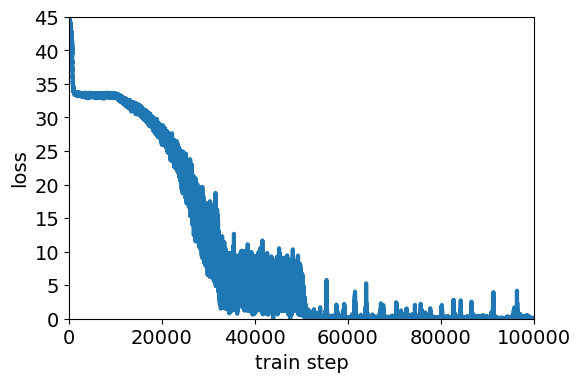

In [10]:
loss_hist = log.read('loss')
f = plt.figure(figsize=[6,4], dpi=100)

plt.plot(loss_hist[:,0], loss_hist[:,1], linewidth=3.0, label='loss')
plt.xlabel('train step', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('loss', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)
plt.ylim([0,45])
plt.xlim([0,100000])
plt.show(f) #; f.savefig('loss-{}.png'.format(FLAGS.cipher), bbox_inches='tight')

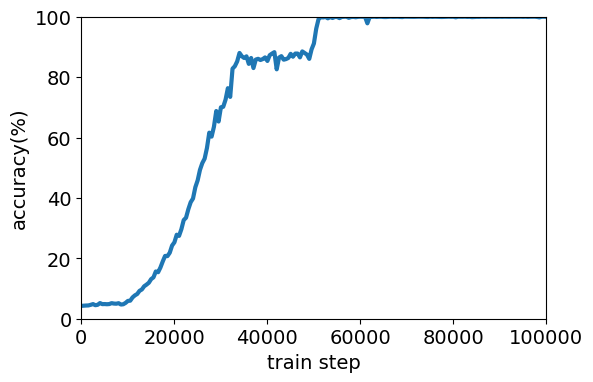

In [7]:
acc_hist = log.read('acc')
f = plt.figure(figsize=[6,4], dpi=100)

plt.plot(acc_hist[:,0], acc_hist[:,1], linewidth=3.0, label='accuracy')
plt.xlabel('train step', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('accuracy(%)', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)
plt.ylim([0,100])
plt.xlim([0,100000])
plt.show(f) #; f.savefig('acc-{}.png'.format(FLAGS.cipher), bbox_inches='tight')

## Accuracy vs memory size

Helps us get a ballpark estimate for the minimum LSTM cell size we need to solve this task

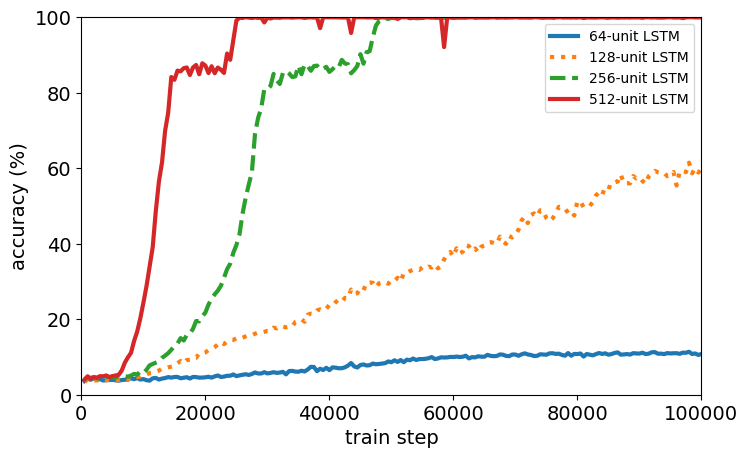

In [12]:
MEM_SIZES = [64,128,256,512]
FLAGS.var_mem = True

f = plt.figure(figsize=[8,5], dpi=100)
styles = ['-', ':', '--', '-']
for i, m in enumerate(MEM_SIZES):
    FLAGS.rnn_size = m
    
    FLAGS.meta_dir = '../meta/' + FLAGS.cipher + '-{}/'.format(m) # directory to save loss history, figures, etc.
    FLAGS.save_dir = '../save/' + FLAGS.cipher + '-{}/'.format(m) # directory to save model
    log = Logger(FLAGS)
    loss_hist = log.read('loss')
    acc_hist = log.read('acc')

    plt.plot(acc_hist[:,0], acc_hist[:,1], linewidth=3.0, label=str(m) + '-unit LSTM', ls=styles[i])
    
plt.xlabel('train step', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('accuracy (%)', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)
plt.ylim([0,100])
plt.xlim([0,100000])
plt.legend()

plt.show(f) #; f.savefig('memory-{}.png'.format(FLAGS.cipher), bbox_inches='tight')

## Does the model generalize?

We'll measure generalization by having the model decode much longer sequences of ciphertext than it was trained on. First, we define a modified accuracy function which measures accuracy over a variable number of time steps.

In [13]:
def accuracy(model, data, steps=None):
    if steps is None: steps = data.wordlen
    mean_acc = 0 ; trials = 50
    kl = data.key_len
    assert data.wordlen >= steps, '# generalize steps should be <= than number train time steps minus key length'
    step_lim = steps + kl
    for _ in range(trials):
        batch = data.next_batch(model.batch_size)
        y = np.stack(batch[1])
        y_hat = model.decode(batch[0])
        mean_acc += np.sum(y[:,kl:step_lim,:]*y_hat[:,kl:step_lim,:])/(y.shape[0]*steps) # TODO: make this less awk
    return mean_acc * 100 / trials

Now, we reload the model with a large number of time steps so that we can test it on longer sequences than it was trained on.

In [14]:
# increase number of tsteps to 200
FLAGS.meta_dir = '../meta/' + FLAGS.cipher + '/'
FLAGS.save_dir = '../save/' + FLAGS.cipher+ '/'
FLAGS.rnn_size = 256
FLAGS.tsteps = 200 + FLAGS.key_len + 1

tf.reset_default_graph()
sess = tf.InteractiveSession()
data.change_tsteps(FLAGS.tsteps)
model = StackedRNN(FLAGS=FLAGS) # model for analyzing the data
global_step = model.try_load_model()

INFO:tensorflow:Restoring parameters from ../save/autokey/model.ckpt-250000
loaded model: ../save/autokey/model.ckpt-250000


Here's the loop where we explore accuracies for various message lengths.

In [15]:
k = 10 # sample every k number of time steps
msg_len_hist = []
max_msg_len = model.tsteps - data.key_len
msg_lens = list(range(k,max_msg_len,k))

for msg_len in msg_lens:
    start_time = time.time()
    
    acc = accuracy(model, data, steps=msg_len)
    msg_len_hist += [[msg_len, acc]]
    
    percent_done = 100*msg_len/max_msg_len
    time_left = (time.time() - start_time) * sum([int(l > msg_len) for l in msg_lens])
    print('progress: {:.1f}% | time left: {:.1f} sec | msg_len: {} | acc: {:.2f}'
          .format(percent_done, time_left, msg_len, acc), end='\r')

warning! key was "KEY" but now is "G"c | msg_len: 20 | acc: 99.97
warning! key was "KEY" but now is "FDM"| msg_len: 40 | acc: 99.91


Plot results and save to a numpy file so that we can construct a plot across all three tasks comparing generalization.

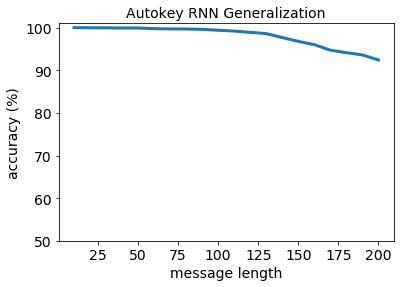

In [16]:
mlh = np.vstack(msg_len_hist)
f = plt.figure(figsize=[6,4])

plt.plot(mlh[:,0], mlh[:,1], linewidth=3.0, label='accuracy')
title = '{} RNN Generalization'.format(FLAGS.cipher[0].upper() + FLAGS.cipher[1:])
plt.title(title, fontsize=14)
plt.xlabel('message length', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('accuracy (%)', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)
plt.ylim([50,101])

plt.show(f)
np.savetxt('saved_np_arrays/generalize-{}.txt'.format(FLAGS.cipher), mlh, delimiter=',')

## How does the memory vector behave?

This is meant to be a qualitative analysis of the RNN's memory cell activations. We hope to get a vague idea of how it's solving the task.

In [24]:
# put the tsteps back to a decent size
FLAGS.meta_dir = '../meta/' + FLAGS.cipher + '/'
FLAGS.save_dir = '../save/' + FLAGS.cipher + '/'
FLAGS.tsteps = 15
FLAGS.batch_size=1

tf.reset_default_graph()
sess = tf.InteractiveSession()
data.change_tsteps(FLAGS.tsteps)
model = StackedRNN(FLAGS=FLAGS) # model for analyzing the data
global_step = model.try_load_model()

INFO:tensorflow:Restoring parameters from ../save/autokey/model.ckpt-250000
loaded model: ../save/autokey/model.ckpt-250000


Write a modified `forward` function which returns memory cell activations as a function of time

In [25]:
def forward(model, data, key, plaintext="YOUKNOWNOTHINGJONSNOW", verbose=False):
    ciphertext = key + '-'*(data.key_len - len(key)) + data.encode(key, plaintext)
    plaintext = key + '-'*(data.key_len - len(key)) + plaintext
    
    decoded = ''
    xs, cs, hs, ys = [], [], [], []
    model.reset_states()
    for i in range(len(ciphertext)):
        x = np.tile(data.one_hot(ciphertext[i]),[1,1,1])
        y = np.tile(data.one_hot(plaintext[i]),[1,1,1])

        c, state = model.step(x, return_state=True)
        xs += [x[0,0,:]] ; cs += [state[0][0,:]] ; hs += [state[1][0,:]] ; ys += [y[0,0,:]]

        ix = np.where(c[0,0,:] == np.amax(c[0,0,:]))
        ix = np.squeeze(ix[0])
        if ix <= 25: # TODO: make this less awk
            decoded += data.A[ix]
        else:
            decoded += '-'

    xs = np.vstack(xs).T ; cs = np.vstack(cs).T ; hs = np.vstack(hs).T ; ys = np.vstack(ys).T
    if verbose:
        print( "\t\tplaintext is:  '{}'".format(plaintext) )
        print( "\t\tciphertext is: '{}'".format(ciphertext) )
        print( "\t\tprediction is: '{}'".format(decoded) )
    return decoded, xs, cs, hs, ys

### Time to look at a particular sequence in detial...

In [26]:
key = "ABC" ; plaintext = "DEFGHIJKLMNOPQRSTUVWX" # the alphabet
# key = "ACE" ; plaintext = "GIKMOQSUWYACEGIKMOQSU" # every other letter of the alphabet
# key = "ADG" ; plaintext = "JMPSVYBEHKNQTWZCFILOR" # every third letter of the alphabet

decoded, xs, cs, hs, ys = forward(model, data, key, plaintext=plaintext)
ciphertext = key + '-'*(data.key_len - len(key)) + data.encode(key, plaintext)
plaintext = key + '-'*(data.key_len - len(key)) + plaintext

print("Let's look at this sequence in detail:")
print( "\tplaintext is:  '{}'".format(plaintext) )
print( "\tciphertext is: '{}'".format(ciphertext) )
print( "\tprediction is: '{}'".format(decoded) )

Let's look at this sequence in detail:
	plaintext is:  'ABC---DEFGHIJKLMNOPQRSTUVWX'
	ciphertext is: 'ABC---DFHJLNPRTVXZBDFHJLNPR'
	prediction is: 'ABC---DEFGHIJKLMNOPQRSTUVWX'


Obtain all the Caesar shifts between plaintext and ciphertext

In [27]:
shifts = [(FLAGS.A.find(ciphertext[i]) - FLAGS.A.find(c))%26 if i >= FLAGS.key_len \
       else 0 for i, c in enumerate(decoded)]
shifts = ' '.join([str(s).rjust(2) for s in shifts]).replace('-1', '--')
print(shifts)

 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20


Obtain all the character indices of the decoded text

In [28]:
char_ixs = [FLAGS.A.find(c) for c in decoded]
char_ixs = ' '.join([str(s).rjust(2) for s in char_ixs]).replace('-1', ' -')
chars = ' ' + '  '.join(decoded)
print(char_ixs, '\n', chars)

 0  1  2  -  -  -  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
  A  B  C  -  -  -  D  E  F  G  H  I  J  K  L  M  N  O  P  Q  R  S  T  U  V  W  X


### Plot the entire $c$ memory vector

Let's look first at how the full memory vector changes with time

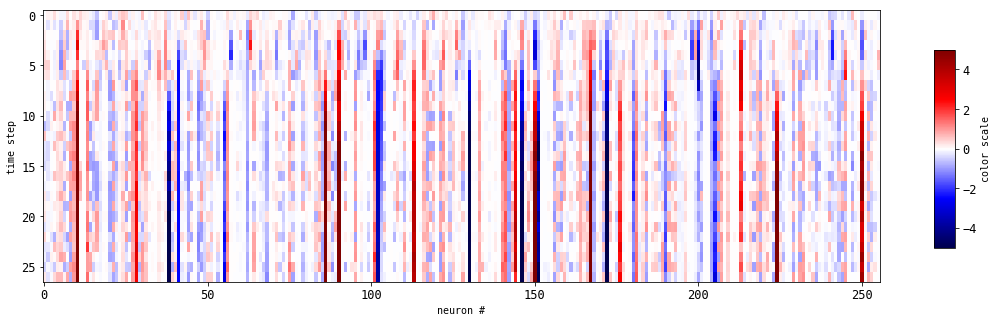

In [29]:
f = plt.figure(figsize=[15,5])
img = cs.T
p = plt.imshow(img, cmap='seismic', aspect='auto')
plt.xlabel("neuron #") ; plt.ylabel("time step")

plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)

plt.clim([-5,5])
cax = f.add_axes([0.95, 0.22, 0.02, 0.55])
cb = f.colorbar(p, cax=cax, orientation='vertical')
cb.set_label('color scale')
plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)
plt.show(f)

### Pick a few neurons randomly
We do this in hopes of finding interesting neuron-level patterns

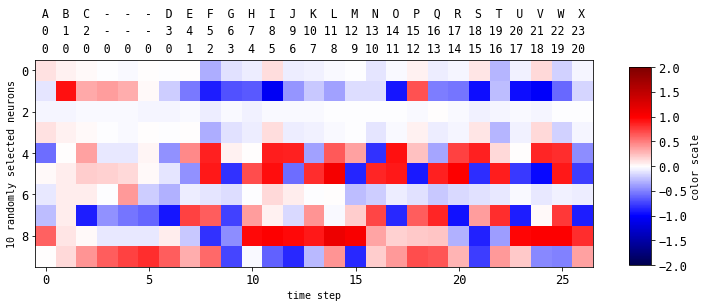

In [30]:
f = plt.figure(figsize=[10,5])
ixs = np.random.randint(256, size=10) ; img = cs[ixs,:]
p = plt.imshow(img, cmap='seismic')
plt.xlabel("time step") ; plt.ylabel("10 randomly selected neurons")

plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)

# add metadata to aid interpretability
plt.rcParams["font.family"] = "monospace"
f.text(0.125, .92, ''.join(chars), ha='left', va='center', fontsize=11.56)
f.text(0.125, .87, ''.join(char_ixs), ha='left', va='center', fontsize=11.56)
f.text(0.125, .82, ''.join(shifts), ha='left', va='center', fontsize=11.56)

plt.clim([-2,2]) # most values fall in this range (but some have magnitudes over 10!)
cax = f.add_axes([0.95, 0.22, 0.03, 0.55])
cb = f.colorbar(p, cax=cax, orientation='vertical')
cb.set_label('color scale')
plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)

plt.show(f)

### Explore one neuron in particular
With help from the previous picture, we'll zoom in on a single interesting neuron. Neuron 30, for example, seems to be a 'shift neuron' - its activation is correlated with the net shift applied to the ciphertext at a given time step.

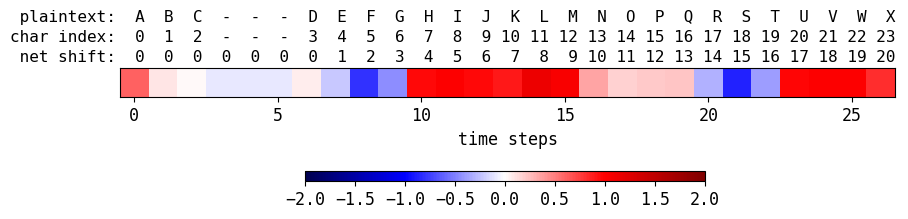

In [31]:
f = plt.figure(figsize=[10,2], dpi=100)
ix = 30 # we found this neuron after looking through many activations and choosing an interesting one
img = cs[ix:ix+1,:]
p = plt.imshow(img, cmap='seismic')

plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel('time steps', fontsize=12)

# add metadata to aid interpretability
plt.rcParams["font.family"] = "monospace"
f.text(0.015, .83, ' plaintext: ' + ''.join(chars), ha='left', va='center', fontsize=11.56)
f.text(0.015, .73, 'char index: ' + ''.join(char_ixs), ha='left', va='center', fontsize=11.56)
f.text(0.015, .63, ' net shift: ' + ''.join(shifts), ha='left', va='center', fontsize=11.56)

plt.clim([-2,2])
cax = f.add_axes([0.31, 0.01, 0.4, 0.05])
cb = f.colorbar(p, cax=cax, orientation='horizontal')
plt.setp(plt.gca().axes.get_xticklabels(), fontsize=12)
plt.setp(plt.gca().axes.get_yticklabels(), fontsize=12)

plt.show(f) #; f.savefig('neurons/shift-a1seq-{}.png'.format(FLAGS.cipher), bbox_inches='tight')